# Notebook to make figure for initial shelfstrat conditions.
In this iteration, we show a plan view of initial salinity, then two cross sections: 1 of potential temperature, the other of the along-shelf velocity with the isopycnals overlayed 

In [1]:
#Packages 
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
from datetime import datetime
import glob
from xhistogram.xarray import histogram
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.ticker as tick
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator
from xhistogram.xarray import histogram
from datetime import timedelta
import warnings
warnings.filterwarnings("ignore") #The chaotic option, used to suppress issues with cf_time with xroms 

### Open model output 

In [2]:
path1 = '/d1/shared/shelfstrat_wind/43N_open/shelf_dx_500_uwind_0_f_43N/shelf_dx_500_uwind_0_f_43N_open_his.nc'
ds = xroms.open_netcdf(path1)
ds, grid = xroms.roms_dataset(ds)

In [14]:
#Interpolate vertical coordinate for plotting
zw_u = grid.interp(ds.z_w, 'X')
zw_u = zw_u.assign_coords({"x_u": ds.x_u})

#x/y coordinates
xrho = (ds.x_rho/1000).values
yrho = (ds.y_rho/1000).values

#Temperature
temp = grid.interp(ds.temp,'X')
temp = temp.assign_coords({'z_rho_u':(ds.z_rho_u),'y_u':(ds.y_u),'xi_u':(ds.xi_u)})

#Density from linear EOS
rhol = 1027*((1+7.6*(10**-4*(ds.salt-35)))-1.7*10**-4*(ds.temp-25))
rhol = grid.interp(rhol,'X')
rhol = grid.interp(rhol,'Z', boundary = 'extend')
rhol = rhol.assign_coords({'z_w_u':(ds.z_w_u),'y_u':(ds.y_u)})

### Split this into two subplots and combine them offline 

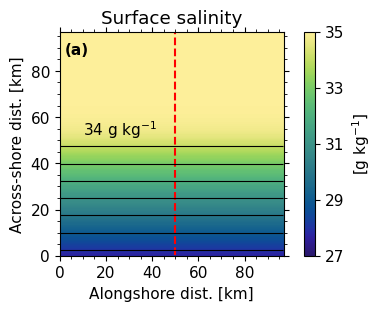

In [50]:
plt.rcParams.update({'font.size': 11})
nrows = 1; ncols = 1
fig, ax = plt.subplots(nrows,ncols, figsize = (4,3), constrained_layout = True)

#Plot plan view of surface salinity 
m = ax.pcolormesh(xrho, yrho, ds.salt[0,-1].values, cmap = cmo.haline, vmin = 27, vmax = 35)
cbar = fig.colorbar(m, ax = ax, label = '[g kg$^{-1}$]', ticks = [27, 29, 31, 33, 35])
ax.plot(ds.x_u[:,99]/1000, ds.y_u[:,99]/1000, lw = 1.5, ls = '--', c = 'r')
ax.contour(xrho, yrho, ds.salt[0,-1].values, levels = np.arange(28,36), colors = 'black', linewidths = 0.8, inline = True)

#Add subplot labels 
ax.text(2,87,'(a)', fontweight = 'semibold')
ax.set(xlim=[0,97], ylim=[0,97])
ax.set_xticks(np.arange(0,100,20))
minor_locator = AutoMinorLocator(2)
ax.tick_params(which = 'both',bottom=True, top=True, left=True, right=True)
ax.tick_params(which = 'both',labelbottom=True, labeltop=False, labelleft=True, labelright=False)
ax.minorticks_on()
ax.set_xticks([0,20,40,60,80])
ax.set_xticklabels(['0', '20', '40', '60', '80'])
ax.set_yticks([0,20,40,60,80])
ax.set_yticklabels(['0', '20', '40', '60', '80'])
ax.set_xlabel('Alongshore dist. [km]')
ax.set_ylabel('Across-shore dist. [km]')
ax.set_title('Surface salinity')
ax.set_aspect('equal')
ax.text(10,52, r'34 g kg$^{-1}$', color = 'black')

plt.savefig('initial_salinity.png', dpi = 300, bbox_tight= True)

In [48]:
print(temp.isel(ocean_time = 0, xi_u = 50, eta_rho = slice(1,-1)).min().values)
print(temp.isel(ocean_time = 0, xi_u = 50, eta_rho = slice(1,-1)).max().values)

19.35046
25.0


In [45]:
print(ds.u.isel(ocean_time = 0, xi_u = 50, eta_rho = slice(1,-1)).min().values)
print(ds.u.isel(ocean_time = 0, xi_u = 50, eta_rho = slice(1,-1)).max().values)

6.069931e-06
0.5334603


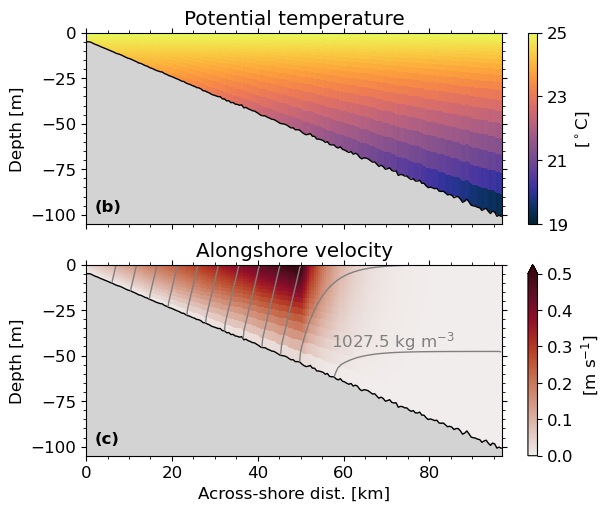

In [51]:
plt.rcParams.update({'font.size': 12})
nrows = 2; ncols = 1
fig, ax = plt.subplots(nrows,ncols, figsize = (6,5), constrained_layout = True)

#Plot cross-section of potential temp
tp = temp.isel(ocean_time = 0, xi_u = 50).plot(ax = ax[0], x = 'y_u', y = 'z_rho_u', 
                                               cmap = cmo.thermal, vmin = 19, vmax = 25, add_colorbar = False)
cbar = fig.colorbar(tp, ax = ax[0], label = '[$^\circ$C]', ticks = [19,21,23,25])
zw_u.isel(ocean_time = 0, s_w = 0, xi_u = 50).plot(ax = ax[0], x = 'y_u', c = 'k', lw = 1.0)

#Plot cross section of u velocity with density contours 
uplt = ds.u.isel(ocean_time = 0, xi_u = 50).plot(ax = ax[1], x = 'y_u', y = 'z_rho_u', 
                                                 cmap = cmo.amp, vmin = 0, vmax = 0.5, add_colorbar = False)
zw_u.isel(ocean_time = 0, s_w = 0, xi_u = 50).plot(ax = ax[1], x = 'y_u', c = 'k', lw = 1)

rhoplt = rhol.isel(ocean_time = 0, xi_u = 50).plot.contour(x = 'y_u', y = 'z_w_u', levels = np.arange(1022,1030,0.5),                                                            
                                                           colors = 'gray', inline = False, linewidths = 1)
cbar = fig.colorbar(uplt, ax = ax[1], label = '[m s$^{-1}$]', extend = 'max')

for i in range(2):
    ax[i].set_ylim(-105,0)
    ax[i].set_xlabel('Across-shore dist. [km]')
    ax[i].set_xticklabels(['0', '20', '40', '60', '80'])
    ax[i].set_xticks([0,20e3,40e3,60e3,80e3])
    ax[i].tick_params(which = 'both',bottom=True, top=True, left=True, right=True)
    ax[i].tick_params(which = 'both',labelbottom=True, labeltop=False, labelleft=True, labelright=False)
    ax[i].minorticks_on()
    ax[i].set_ylabel('Depth [m]')
    
ax[0].set_xticklabels('')
ax[0].set_xlabel('')
ax[0].set_title(r'Potential temperature')
ax[0].text(2000,-98,'(b)', fontweight = 'semibold')
ax[0].set_facecolor('lightgray')

ax[1].set_title(r'Alongshore velocity')
ax[1].text(2000,-98,'(c)', fontweight = 'semibold')
ax[1].text(57e3, -45, '1027.5 kg m$^{-3}$', color = 'gray')
ax[1].set_facecolor('lightgray')

plt.savefig('initial_cs.png', dpi = 300, bbox_tight= True)

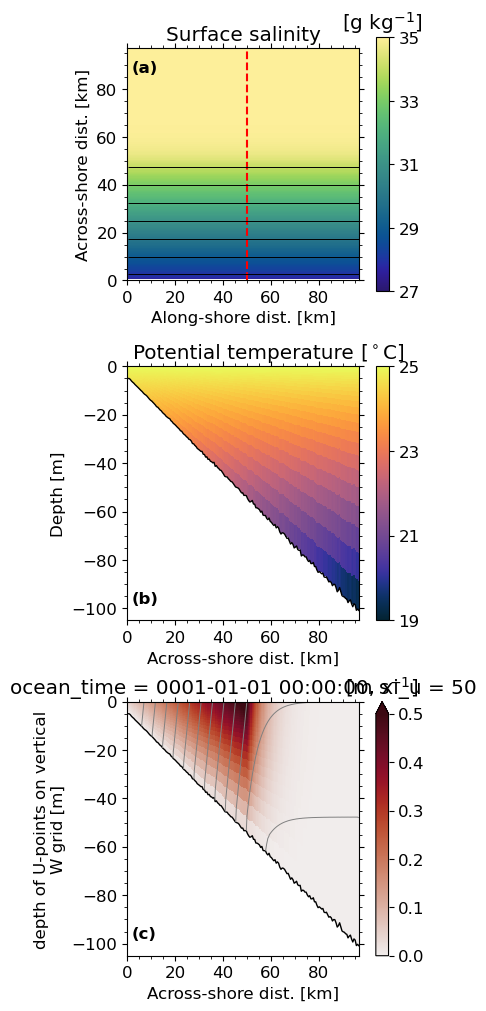

In [8]:
plt.rcParams.update({'font.size': 12})
nrows = 3; ncols = 1
fig, ax = plt.subplots(nrows,ncols, figsize = (4,10), constrained_layout = True)

#Plot plan view of surface salinity 
m = ax[0].pcolormesh(xrho, yrho, ds.salt[0,-1,1:].values, cmap = cmo.haline, vmin = 27, vmax = 35)
cbar = fig.colorbar(m, ax = ax[0], label = '', ticks = [27, 29, 31, 33, 35])
cbar.ax.set_title(r'[g kg$^{-1}$]')
ax[0].plot(ds.x_u[:,99]/1000, ds.y_u[:,99]/1000, lw = 1.5, ls = '--', c = 'r')
ax[0].contour(xrho, yrho, ds.salt[0,-1,1:].values, levels = np.arange(28,36), colors = 'black', linewidths = 0.7, inline = True)

#Plot cross-section of potential temp
tp = temp.isel(ocean_time = 0, xi_u = 50).plot(ax = ax[1], x = 'y_u', y = 'z_rho_u', cmap = cmo.thermal, vmin = 19, vmax = 25, add_colorbar = False)
cbar = fig.colorbar(tp, ax = ax[1], label = '', ticks = [19,21,23,25])
cbar.ax.set_title('[$^\circ$C]')
zw_u.isel(ocean_time = 0, s_w = 0, xi_u = 50).plot(ax = ax[1], x = 'y_u', c = 'k', lw = 1.0)

#Plot cross section of u velocity with density contours 
uplt = ds.u.isel(ocean_time = 0, xi_u = 50).plot(ax = ax[2], x = 'y_u', y = 'z_rho_u', cmap = cmo.amp, vmin = 0, vmax = 0.5, add_colorbar = False)
zw_u.isel(ocean_time = 0, s_w = 0, xi_u = 50).plot(ax = ax[2], x = 'y_u', c = 'k', lw = 1)

rhoplt = rhol.isel(ocean_time = 0, xi_u = 50).plot.contour(x = 'y_u', y = 'z_w_u', levels = np.arange(1022,1030,0.5), 
                                                           colors = 'gray', inline = False, linewidths = 0.7)
cbar = fig.colorbar(uplt, ax = ax[2], label = '', extend = 'max')
cbar.ax.set_title('[m s$^{-1}$]')

#Add subplot labels 
ax[0].text(2,87,'(a)', fontweight = 'semibold')
ax[1].text(2000,-98,'(b)', fontweight = 'semibold')
ax[2].text(2000,-98,'(c)', fontweight = 'semibold')

for j in range(1):
    ax[j].set(xlim=[0,97], ylim=[0,97])
    ax[j].set_xticks(np.arange(0,100,20))
    minor_locator = AutoMinorLocator(2)
    ax[j].tick_params(which = 'both',bottom=True, top=True, left=True, right=True)
    ax[j].tick_params(which = 'both',labelbottom=True, labeltop=False, labelleft=True, labelright=False)
    ax[j].minorticks_on()
    ax[j].set_xticks([0,20,40,60,80])
    ax[j].set_xticklabels(['0', '20', '40', '60', '80'])
    ax[j].set_yticks([0,20,40,60,80])
    ax[j].set_yticklabels(['0', '20', '40', '60', '80'])
    ax[j].set_xlabel('Along-shore dist. [km]')
    ax[j].set_aspect('equal')

ax[0].set_ylabel('Across-shore dist. [km]')
ax[0].set_title('Surface salinity')
ax[1].set_title(r'Potential temperature')
ax[1].set_ylabel('Depth [m]')
for i in range(2):
    ax[i+1].set_ylim(-105,0)
    ax[i+1].set_xlabel('Across-shore dist. [km]')
    ax[i+1].set_xticklabels(['0', '20', '40', '60', '80'])
    ax[i+1].set_xticks([0,20e3,40e3,60e3,80e3])
    ax[i+1].tick_params(which = 'both',bottom=True, top=True, left=True, right=True)
    ax[i+1].tick_params(which = 'both',labelbottom=True, labeltop=False, labelleft=True, labelright=False)
    ax[i+1].minorticks_on()

TypeError: __init__() got an unexpected keyword argument 'size'

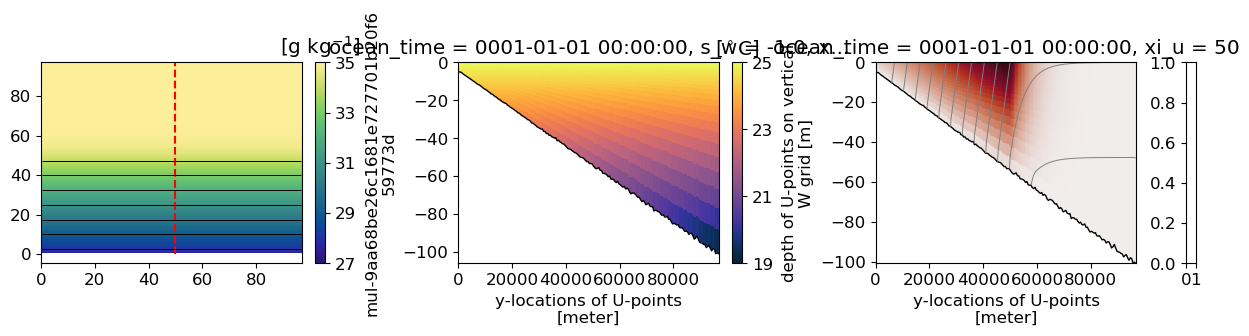

In [14]:
plt.rcParams.update({'font.size': 12})
nrows = 3; ncols = 1
fig, ax = plt.subplots(nrows,ncols, figsize = (3,12), constrained_layout = True)

#Plot plan view of surface salinity 
mappable = ax[0].pcolormesh(xrho, yrho, ds.salt[0,-1,1:].values, cmap = cmo.haline, vmin = 27, vmax = 35)
cbar = fig.colorbar(mappable, ax = ax[0], label = '', ticks = [27, 29, 31, 33, 35])
cbar.ax.set_title(r'[g kg$^{-1}$]')
ax[0].plot(ds.x_u[:,99]/1000, ds.y_u[:,99]/1000, lw = 1.5, ls = '--', c = 'r')

ax[0].contour(xrho, yrho, ds.salt[0,-1,1:].values, levels = np.arange(28,36), colors = 'black', linewidths = 0.7, inline = True)

#Plot cross-section of potential temp
tp = temp.isel(ocean_time = 0, xi_u = 50).plot(ax = ax[1], x = 'y_u', y = 'z_rho_u', cmap = cmo.thermal, vmin = 19, vmax = 25, add_colorbar = False)
cbar = fig.colorbar(tp, ax = ax[1], label = '', ticks = [19,21,23,25])
cbar.ax.set_title('[$^\circ$C]')
zw_u.isel(ocean_time = 0, s_w = 0, xi_u = 50).plot(ax = ax[1], x = 'y_u', c = 'k', lw = 1.0)

#Plot cross section of u velocity with density contours 
uplt = ds.u.isel(ocean_time = 0, xi_u = 50).plot(ax = ax[2], x = 'y_u', y = 'z_rho_u', cmap = cmo.amp, vmin = 0, vmax = 0.5, add_colorbar = False)
zw_u.isel(ocean_time = 0, s_w = 0, xi_u = 50).plot(ax = ax[2], x = 'y_u', c = 'k', lw = 1)

rhoplt = rhol.isel(ocean_time = 0, xi_u = 50).plot.contour(x = 'y_u', y = 'z_w_u', levels = np.arange(1022,1030,0.5), 
                                                           colors = 'gray', inline = False, linewidths = 0.7)
# ax[2].clabel(rhoplt, rhoplt.levels[-5:])
cbar = fig.colorbar(uplt, ax = ax[2], label = '', extend = 'max', size = '.5f')
cbar.ax.set_title('[m s$^{-1}$]')

#Add subplot labels 
ax[0].text(2,87,'(a)', fontweight = 'semibold')
ax[1].text(2000,-98,'(b)', fontweight = 'semibold')
ax[2].text(2000,-98,'(c)', fontweight = 'semibold')

for j in range(1):
    ax[j].set(xlim=[0,97], ylim=[0,97])
    ax[j].set_xticks(np.arange(0,100,20))
    minor_locator = AutoMinorLocator(2)
    ax[j].tick_params(which = 'both',bottom=True, top=True, left=True, right=True)
    ax[j].tick_params(which = 'both',labelbottom=True, labeltop=False, labelleft=True, labelright=False)
    ax[j].minorticks_on()
    ax[j].set_xticks([0,20,40,60,80])
    ax[j].set_xticklabels(['0', '20', '40', '60', '80'])
    ax[j].set_yticks([0,20,40,60,80])
    ax[j].set_yticklabels(['0', '20', '40', '60', '80'])
    ax[j].set_xlabel('Along-shore dist. [km]')
    ax[j].set_aspect('equal')

ax[0].set_ylabel('Across-shore dist. [km]')
ax[0].set_title('Surface salinity')
ax[1].set_title(r'Potential temperature')
ax[1].set_ylabel('Depth [m]')
for i in range(2):
    ax[i+1].set_ylim(-105,0)
    ax[i+1].set_xlabel('Across-shore dist. [km]')
    ax[i+1].set_xticklabels(['0', '20', '40', '60', '80'])
    ax[i+1].set_xticks([0,20e3,40e3,60e3,80e3])
    ax[i+1].tick_params(which = 'both',bottom=True, top=True, left=True, right=True)
    ax[i+1].tick_params(which = 'both',labelbottom=True, labeltop=False, labelleft=True, labelright=False)
    ax[i+1].minorticks_on()

ax[2].set_title('Along-shore velocity')
ax[2].set_ylabel('')
ax[2].set_yticklabels('')

ax[1].set_facecolor('lightgray')
ax[2].set_facecolor('lightgray')

ax[2].text(53e3, -45, '1027.5 kg m$^{-3}$', color = 'gray')
ax[0].text(10,52, r'34 g kg$^{-1}$', color = 'black')

# ax[0].spines[:].set_linewidth(2)
# plt.savefig('initial_conditions.jpg', dpi = 300, bbox_tight= True)

### Get vertical resolution in top 1 m averaged over initially stratified region and whole domain

In [29]:
ds.dz[0].where(ds.z_rho[0]>-1).mean().values

array(0.18908855)

In [30]:
ds.dz[0,:,1:100,1:-1].where(ds.z_rho[0,:,1:100,1:-1]>-1).mean().values

array(0.1640669)

In [31]:
ds.dz[0].mean().values

array(1.75829169)

In [32]:
ds.dz[0,:,1:100,1:-1].mean().values

array(0.98329773)